<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Mar 16 11:01:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameters

In [2]:
# hyperparameters
batch_size = 64 # num independent sequences processed in parallel 
sequence_length = 257 # p^2 + 1

dropout = 0.2
learning_rate = 3e-4

# model architecture
n_heads = 6
n_embedding = 384 # each head has dim 64 (=384/6)
n_layer = 1 #6

## Imports

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops

from einops import rearrange, reduce, repeat

einops not installed as required, installing...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.7 MB/s eta 0:00:00


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


## Downloading and pre-processing data

In [5]:
raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
print(raw_dataset.data.shape)
means_all = []
stds_all = []
for i in range(len(raw_dataset)):
  img, _ = raw_dataset[i] #[3, 32, 32]
  means_all.append([img[i].mean() for i in range(3)])
  stds_all.append([img[i].std() for i in range(3)])
means = [round(torch.Tensor(means_all)[:, i].mean().item(), 4) for i in range(3)]
stds = [round(torch.Tensor(stds_all)[:, i].std().item(), 4) for i in range(3)]
print(means, stds)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
(50000, 32, 32, 3)
[0.4914, 0.4822, 0.4465] [0.0606, 0.0612, 0.0677]


In [6]:
means, stds = [0.4914, 0.4822, 0.4465], [0.0606, 0.0612, 0.0677]
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(means, stds)])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
print(f"\nTrain elements: {len(train_dataset)} | Test elements: {len(test_dataset)}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {batch_size}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {batch_size}")
xb, yb = next(iter(train_dataloader))
print(xb.shape, yb.shape)

Files already downloaded and verified
Files already downloaded and verified

Train elements: 50000 | Test elements: 10000
Length of train_dataloader: 782 batches of size 64
Length of test_dataloader: 157 batches of size 64
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [7]:
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {class_to_idx[key]:key for key in class_to_idx}
len(classes), classes[:5]
print([[idx_to_class[x],train_dataset.targets.count(x)] for x in set(train_dataset.targets)])
print([[idx_to_class[x],test_dataset.targets.count(x)] for x in set(test_dataset.targets)])

[['airplane', 5000], ['automobile', 5000], ['bird', 5000], ['cat', 5000], ['deer', 5000], ['dog', 5000], ['frog', 5000], ['horse', 5000], ['ship', 5000], ['truck', 5000]]
[['airplane', 1000], ['automobile', 1000], ['bird', 1000], ['cat', 1000], ['deer', 1000], ['dog', 1000], ['frog', 1000], ['horse', 1000], ['ship', 1000], ['truck', 1000]]


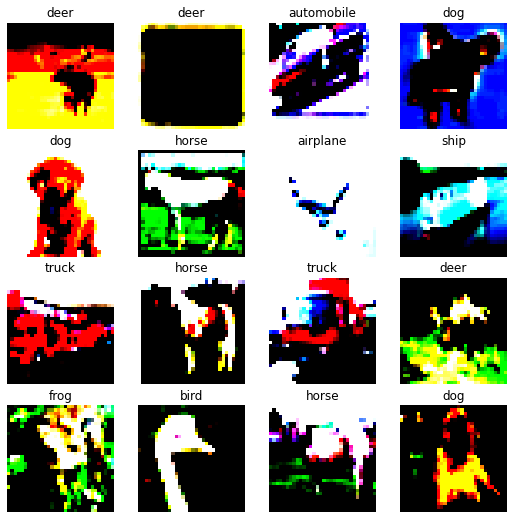

In [8]:
#Visualizing images(after normalization)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size = [1]).item()
  img1, label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img1, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

Files already downloaded and verified


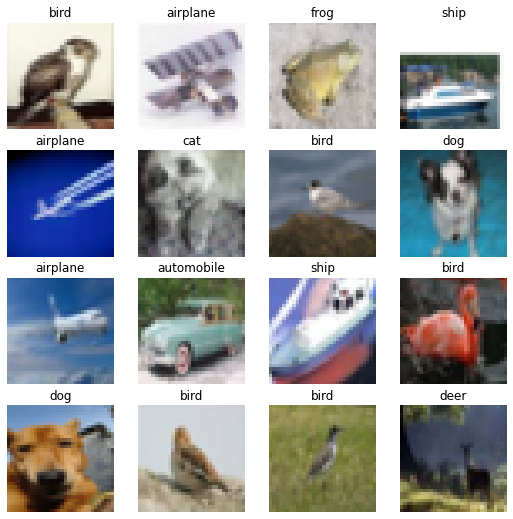

In [9]:
unnormed_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
#Visualizing images(without normalization)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(unnormed_dataset), size = [1]).item()
  img2, label = unnormed_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img2, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

Files already downloaded and verified


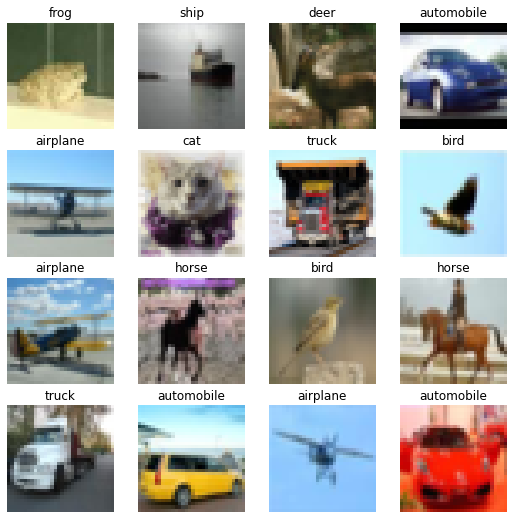

In [10]:
# Visualizing test dataset !!!
unnormed_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
#Visualizing images(without normalization)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(unnormed_test_dataset), size = [1]).item()
  img2, label = unnormed_test_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img2, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

Files already downloaded and verified


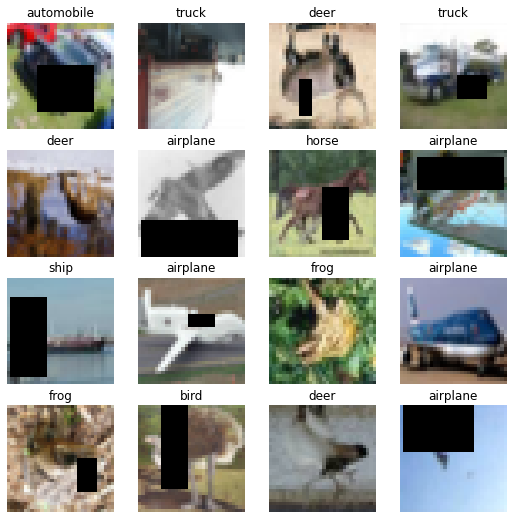

In [11]:
#Visualizing augmented images(without normalization)
data_augmentation_transforms = transforms.Compose(
                      [transforms.ToTensor(),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomVerticalFlip(p=0.5),
                      transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                      transforms.RandomErasing(p=0.5)])

augmentation_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = data_augmentation_transforms)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(augmentation_dataset), size = [1]).item()
  img2, label = augmentation_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img2, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

In [12]:
print(img1.mean(), img1.std())
print(img2.mean(), img2.std())

tensor(-2.4235) tensor(2.4649)
tensor(0.5617) tensor(0.3773)


## Evaluation and Accuracy helper functions

In [13]:
def evaluate_model(model: nn.Module, batch_limit=-1) -> dict:
  t_eval = time.time()
  model.eval()
  with torch.inference_mode():
    splits = ['train', 'test']
    categories = ['loss', 'top1', 'top5']
    all = {'train': {c:[] for c in categories}}
    all['test'] = {c: [] for c in categories}
    for split in splits:
      data_loader = train_dataloader if split == 'train' else test_dataloader
      for batch, (xb, yb) in enumerate(data_loader):
        if batch_limit == batch: break
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = model(xb, yb)
        all[split]['loss'].append(loss.item())
        B = yb.shape[0]
        # top@1 accuracy
        top1_preds = torch.topk(logits, 1, dim = -1).indices
        all[split]['top1'].append(100*torch.sum(top1_preds == rearrange(yb, 'b -> b ()')).item()/B)
        # top@5 accuracy
        top5_preds = torch.topk(logits, 5, dim = -1).indices
        all[split]['top5'].append(100*torch.sum(top5_preds == repeat(yb, 'b -> b k', k=5)).item()/B)

  model.train()
  #technically the last batch could be a different size, and ideally would be weighted here,
  #although it will make negligble input so I'll leave it in this simple (an slightly incorrect) version
  output_dict = {split:list(map(lambda a: round(torch.Tensor(a).mean().item(), 4), all[split].values())) for split in splits}
  output_dict['eval_time'] = round(time.time()-t_eval, 2)
  return output_dict

def format_output(output_dict, epoch, train_time, loss):
  array = [epoch,"|"]+output_dict['train']+['|']+output_dict['test']+['|']+[round(train_time,2),output_dict['eval_time'],'|',round(loss.item(),4)]
  title = 'epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)'
  header= "----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------"
  idxs = [0]
  for j in range(len(title)-1): 
    if title[j] == " " and title[j+1] != " ": idxs.append(j+1)
  output_str = ""
  for i in range(len(idxs)): output_str+=" "*(idxs[i]-len(output_str)) + f"{array[i]}"
  if epoch == 0: output_str= '\n' + header + '\n' + title + '\n' + output_str
  return output_str

## Model

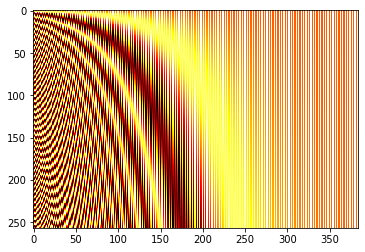

In [14]:
import math
import matplotlib.pyplot as plt
def get_positional_embeddings(sequence_length, n_embedding):
    result = torch.ones(sequence_length, n_embedding).to(device)
    for i in range(sequence_length):
        for j in range(n_embedding):
          if j % 2 == 0:
            result[i][j] = math.sin(i / (10000 ** (j / n_embedding)))
          else:
            result[i][j] = math.cos(i / (10000 ** ((j - 1) / n_embedding)))
    return result

plt.imshow(get_positional_embeddings(sequence_length, n_embedding).cpu(), cmap="hot", interpolation="nearest")
plt.show()

In [21]:
class MultiHeadAttention(nn.Module):
  # parallelized attention heads
  
  def __init__(self):
    super().__init__()
    head_size = n_embedding // n_heads
    self.scale_factor = head_size**-0.5 # This scaling factor makes an INSANE difference

    #generating q,k,v for all n_heads at once
    self.qkv_linear = nn.Linear(n_embedding, head_size*n_heads*3) 
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Sequential(
        nn.Linear(head_size*n_heads, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape #[64, 256, 384])
    qkv = self.qkv_linear(x) # [64, 256, 1152]
    q, k, v =  rearrange(qkv, 'b t (qvk h c) -> qvk b h t c', qvk=3, h=n_heads) #torch.Size([3, 64, 6, 256, 64])

    mat_mul = q@rearrange(k, 'b h t c -> b h c t') * self.scale_factor
    mat_mul = nn.functional.softmax(mat_mul, dim = -1)
    mat_mul = self.dropout(mat_mul)
    mat_mul = mat_mul@v
    flattened = rearrange(mat_mul, 'b h t c -> b t (h c)')
    linear = self.linear(flattened)
    return flattened

class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(n_embedding, 4*n_embedding),
        nn.GELU(),
        nn.Linear(4*n_embedding, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.feed_forward(x)

class Transformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.multi_attention = MultiHeadAttention() 
    self.feed_forward = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embedding)
    self.ln2 = nn.LayerNorm(n_embedding)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.multi_attention(self.ln1(x))
    x = x + self.feed_forward(self.ln2(x))
    return x

class ViT(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv = nn.Conv2d(in_channels=3,
                  out_channels=n_embedding,
                  kernel_size=(2, 2),
                  stride=2)
      self.learnable_embedding = nn.Parameter(torch.randn(n_embedding))
      self.positional_encodings = nn.Parameter(get_positional_embeddings(sequence_length, n_embedding))
      self.transformers = nn.Sequential(*[Transformer() for _ in range(n_layer)])
      self.final_ln = nn.LayerNorm(n_embedding)
      self.final_linear = nn.Sequential(
          nn.Linear(n_embedding, 4*len(classes)),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(4*len(classes), len(classes)))
          #nn.Linear(n_embedding, len(classes))
  #     self.apply(self._init_weights)

  # def _init_weights(self, module): # stolen from karpathy, (originally for gpt)
  #   if isinstance(module, nn.Linear):
  #       torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
  #       if module.bias is not None:
  #           torch.nn.init.zeros_(module.bias)

  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    B = x.shape[0]
    x = rearrange(self.conv(x), 'b c h w -> b (h w) c')
    x = torch.cat((repeat(self.learnable_embedding, 'c -> b () c', b = B), x), dim = 1)
    x = x + self.positional_encodings
    x = self.transformers(x)
    x = self.final_ln(x)
    logits = self.final_linear(x[:, 0])
    loss = None if targets == None else nn.functional.cross_entropy(logits, targets)

    return logits, loss

vit_model = ViT().to(device)
print(f'vit model parameters are on device: {next(vit_model.parameters()).device}')
xb, yb = next(iter(train_dataloader))
xb, yb = xb.to(device), yb.to(device)
logits, loss = vit_model(xb, yb)
print(f"{logits.shape}, {loss.item():.4f}")
print(f"{sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")

vit model parameters are on device: cuda:0
torch.Size([64, 10]), 2.2988
1.8951 Million Parameters


In [22]:
optimizer = torch.optim.AdamW(params = vit_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 20) # T_mult=2

In [23]:
data_augmentation_transforms = transforms.Compose(
                      [transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomVerticalFlip(p=0.5),
                      transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                      transforms.RandomErasing(p=0.5)])

logits, loss = vit_model(data_augmentation_transforms(xb), yb)
print(f"{logits.shape}, {loss.item():.4f}")

torch.Size([64, 10]), 2.2884


In [24]:
from tqdm import tqdm
losses = []
lrs = []
output_table = []
output_dicts = []

epochs = 16 # training iterations
eval_interval = 3 # after how many epochs to print out loss & accuracy

t_train = time.time()
t_train_full = time.time()
print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {batch_size}")
print()
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} | num_params: {sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")
#For initial epoch evaluation
xb, yb = xb.to(device), yb.to(device)
_, loss = vit_model(xb, yb)

for epoch in range(epochs):
  if epoch % eval_interval == 0:
    train_time = time.time()-t_train
    output_dict = evaluate_model(vit_model)
    output_dicts.append(output_dict)
    formatted = format_output(output_dict, epoch, train_time, loss)
    output_table.append(formatted)
    print('\n'+formatted)
    t_train = time.time()

  for batch, (xb, yb) in enumerate(train_dataloader):
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = vit_model(data_augmentation_transforms(xb), yb)
    # if batch%200 == 0 : print(f'  ### epoch: {epoch} | batch: {batch} | {loss.item():.4f}')
    losses.append(loss.item())
    lrs.append(scheduler.get_last_lr())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
  scheduler.step()

print(f"\nTime taken for {epochs} epochs: {time.time()-t_train_full:.2f} seconds")
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")
for out in output_table: print(out)

Length of train_dataloader: 782 batches of size 64

n_heads:6 | n_embedding: 384 | n_layer: 1 | num_params: 1.8951 Million Parameters


  0%|          | 0/15 [00:00<?, ?it/s]



----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.3334  8.7756      50.7413   |  2.334   8.9271      50.6469   |  0.01            21.1


 20%|██        | 3/15 [01:26<05:17, 26.45s/it]


3     |  1.3778  50.1978     93.0107   |  1.3996  49.3531     92.705    |  65.17           21.15


 40%|████      | 6/15 [02:53<03:59, 26.58s/it]


6     |  1.2097  56.6736     95.2745   |  1.2626  54.4486     94.5561   |  65.81           21.13


 60%|██████    | 9/15 [04:19<02:38, 26.48s/it]


9     |  1.1777  57.6646     95.6242   |  1.2522  54.2994     94.785    |  65.15           21.29


 80%|████████  | 12/15 [05:45<01:19, 26.47s/it]


12    |  1.0738  61.2232     96.5213   |  1.1852  57.4642     95.2229   |  65.06           21.08


100%|██████████| 15/15 [07:11<00:00, 28.78s/it]


Time taken for 15 epochs: 431.72 seconds
n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.8951 Million Parameters

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.3334  8.7756      50.7413   |  2.334   8.9271      50.6469   |  0.01            21.1
3     |  1.3778  50.1978     93.0107   |  1.3996  49.3531     92.705    |  65.17           21.15
6     |  1.2097  56.6736     95.2745   |  1.2626  54.4486     94.5561   |  65.81           21.13
9     |  1.1777  57.6646     95.6242   |  1.2522  54.2994     94.785    |  65.15           21.29
12    |  1.0738  61.2232     96.5213   |  1.1852  57.4642     95.2229   |  65.06           21.08


In [27]:
evaluate_model(vit_model)

{'train': [1.0247, 63.1434, 96.9889],
 'test': [1.1629, 58.0613, 95.6608],
 'eval_time': 21.37}

In [ ]:
#784*15 =11760, means we are running 10k+ batches through the ViT in 15 epochs
"""
### using 2 linear layers at end, rather than just an embedding

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.3334  8.7756      50.7413   |  2.334   8.9271      50.6469   |  0.01            21.1
3     |  1.3778  50.1978     93.0107   |  1.3996  49.3531     92.705    |  65.17           21.15
6     |  1.2097  56.6736     95.2745   |  1.2626  54.4486     94.5561   |  65.81           21.13
9     |  1.1777  57.6646     95.6242   |  1.2522  54.2994     94.785    |  65.15           21.29
12    |  1.0738  61.2232     96.5213   |  1.1852  57.4642     95.2229   |  65.06           21.08
15: train: 'train': [1.0247, 63.1434, 96.9889], 'test': [1.1629, 58.0613, 95.6608]

### with data_augmentation
Length of train_dataloader: 782 batches of size 64

n_heads:6 | n_embedding: 384 | n_layer: 1 | num_params: 1.8831 Million Parameters
  0%|          | 0/100 [00:00<?, ?it/s]

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.3141  12.7937     53.0031   |  2.3142  12.709      52.4881   |  0.01            20.81
5     |  1.2313  54.4218     95.2645   |  1.2729  53.0056     94.8149   |  106.77          21.04
10    |  1.0559  61.8806     96.881    |  1.1631  57.4443     95.6708   |  106.6           21.15
15    |  0.9587  65.3633     97.4804   |  1.1227  58.9371     95.8997   |  106.71          21.23
 20%|██        | 20/100 [08:33<34:12, 25.66s/it]
 Train and test losses much closer, so there is less overfitting :)
---------------------------------------------------------

 ### without weight init:
Epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.5688  9.9964      48.7272   |  2.5674  10.0418     48.6764   |  0.01            15.3
5     |  1.1747  57.9584     95.4364   |  1.2693  54.4686     94.6059   |  82.39           15.49
10    |  0.863   69.4094     98.0758   |  1.1921  57.8225     95.4518   |  81.77           15.41
10%|█         | 10/100 [03:14<26:33, 17.70s/it]

### with weight init:
  Length of train_dataloader: 782 batches of size 64

n_heads:6 | n_embedding: 384 | n_layer: 1 | num_params: 1.8831 Million Parameters
  0%|          | 0/100 [00:00<?, ?it/s]

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
epoch |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0     |  2.3906  10.0204     50.0      |  2.3917  9.9821      49.8806   |  0.01            14.78
5     |  1.2141  56.3219     95.1966   |  1.2909  52.9658     94.2178   |  79.42           14.74
10    |  0.9001  67.9448     97.8561   |  1.1725  58.6982     95.4717   |  78.39           14.69
15    |  0.6362  77.4976     99.1648   |  1.2602  58.3798     94.9343   |  78.02           14.63
 17%|█▋        | 17/100 [05:35<27:16, 19.71s/it]
"""

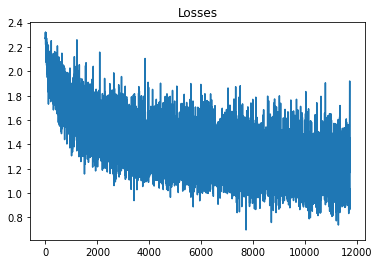

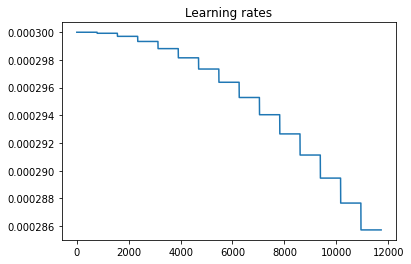

In [25]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Losses")
plt.show()

plt.plot(lrs)
plt.title("Learning rates")
plt.show()

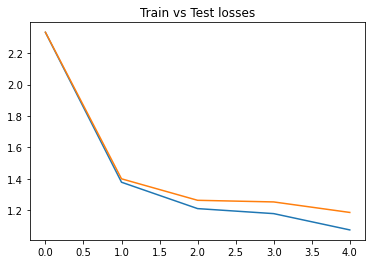

In [26]:
train_losses = []
test_losses = []
for array in output_dicts:
  train_losses.append(array['train'][0])
  test_losses.append(array['test'][0])

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title("Train vs Test losses")
plt.show()


In [ ]:
stop

## Comparing model to finetuning a existing pretrained visual transformer model:

In [ ]:
# Important, pretrained on 224x224 images, so cannot test it out on the cifar10 dataset directly, will have to stretch images

In [ ]:
torchvision.transforms.Resize((224 224))

In [ ]:
# ViT_B_16_Weights.IMAGENET1K_V1.transforms 

In [28]:
import torchvision

weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 	height=224, width=224
vit_pretrained_model = torchvision.models.vit_b_16(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
print(f"{sum(p.numel() for p in vit_pretrained_model.parameters())/1e6:.4f} Million Parameters")

In [ ]:
for param in vit_pretrained_model.parameters(): 
  param.requires_grad = False

for param in vit_pretrained_model.heads.parameters():
  print(param.shape)
  param.requires_grad = True # torch.Size([1000, 768]), torch.Size([1000])

num_outputs = len(classes)
final_layer = nn.Sequential(
        nn.Linear(768, 4*num_outputs),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(4*num_outputs, num_outputs))
vit_pretrained_model.heads = final_layer

In [ ]:
xb, yb = next(iter(train_dataloader))
xb, yb = xb.to(device), yb.to(device)
xb.shape

In [ ]:
output_dict = evaluate_model(vit_pretrained_model)
output_dict

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
# summary(vit_pretrained_model, input_size=[1, 3, 224, 224], col_names =['input_size', 'output_size', 'num_params', 'trainable'])
"""
=================================================================================================================================================
Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
=================================================================================================================================================
VisionTransformer                             [1, 3, 224, 224]          [1, 10]                   768                       Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder: 1-2                                [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout: 2-1                           [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential: 2-2                        [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-7                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-8                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-9                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-10                [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-11                [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-12                [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    └─LayerNorm: 2-3                         [1, 197, 768]             [1, 197, 768]             (1,536)                   False
├─Sequential: 1-3                             [1, 768]                  [1, 10]                   --                        True
│    └─Linear: 2-4                            [1, 768]                  [1, 40]                   30,760                    True
│    └─ReLU: 2-5                              [1, 40]                   [1, 40]                   --                        --
│    └─Dropout: 2-6                           [1, 40]                   [1, 40]                   --                        --
│    └─Linear: 2-7                            [1, 40]                   [1, 10]                   410                       True
=================================================================================================================================================
Total params: 85,829,826
Trainable params: 31,170
Non-trainable params: 85,798,656
Total mult-adds (M): 172.49
=================================================================================================================================================
Input size (MB): 0.60
Forward/backward pass size (MB): 104.09
Params size (MB): 229.32
Estimated Total Size (MB): 334.01
=================================================================================================================================================

original:
...
     └─LayerNorm: 2-3                         [1, 197, 768]             [1, 197, 768]             1,536                     True
├─Sequential: 1-3                             [1, 768]                  [1, 1000]                 --                        True
│    └─Linear: 2-4                            [1, 768]                  [1, 1000]                 769,000                   True
"""
2